# Proceso de preparación de los datos
En este notebook se realizará el proceso completo de desarrollo de un análisis de regresión sobre un conjunto de datos seleccionado.

### Importar bibliotecas y Preparar los Datos de Análisis

En primer lugar debemos Instalar e importar Bibliotecas necesarias:

In [18]:
# Instalar bibliotecas
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install sklearn
#!pip install ipywidgets
!pip install xgboost

In [45]:
#Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from ipywidgets import interact
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
%matplotlib inline 

Luego se debe cargar los datos y guardarlos en el dataframe `df`.

In [7]:
path='datos/Datos_Procesados.csv' # ruta de datos
df = pd.read_csv(path)

### Información inicial sobre el conjunto de datos


Se va a trabajar con un conjunto de datos capturado por un Nodo de sensores ubicado en el 5to Piso - Sector Neonatología del Hospital Regional Guillermo Grant Benavente de la ciudad de Concepción, Chile, **`Datos_Procesados.csv`**. Este conjunto de datos contiene valores referentes al confort termico y la calidad del aire en el sector mencionado del hospital.

*   **id**         -  ID del dato en la BD
*   **timestamp**  - Fecha y hora del dato capturado
*   **ppd**        - Porcentaje de Personas Insatisfechas
*   **pmv**        - Voto Medio Previsto, estima la sensación térmica
*   **hr**         - Humedad Relativa
*   **temp**       - Temperatura
*   **co**         - Monoxido de Carbono
*   **co2**        - Dioxido de Carbono
*   **no2**        - Dioxido de Nitrogeno
*   **c2h5ch**     - Etanol C2H5OH
*   **voc**        - Compuestos Orgánicos Volatiles
*   **pm10**       - Dioxido de Carbono
*   **pm25**       - Material Particulado Grueso
*   **idnodo**     - ID del nodo capturador de datos


Revisamos el tipo de dato de nuestras variables dentro del conjunto de datos para ver con qué tipo de variable se está tratando. Esto nos ayudará a encontrar el método de visualización adecuado para cada variable.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1440 non-null   int64  
 1   id                  1440 non-null   int64  
 2   timestamp           1440 non-null   object 
 3   pmv                 1440 non-null   float64
 4   ppd                 1440 non-null   float64
 5   co2                 1440 non-null   float64
 6   pm25                1440 non-null   float64
 7   pm10                1440 non-null   float64
 8   temp                1440 non-null   float64
 9   hr                  1440 non-null   float64
 10  voc                 1440 non-null   float64
 11  co                  1440 non-null   float64
 12  no2                 1440 non-null   float64
 13  c2h5ch              1440 non-null   float64
 14  idnodo              1440 non-null   object 
 15  temp(K)             1440 non-null   float64
 16  pm25-c

Como nuestro conjunto de datos ya pasó por un proceso de `Data Wrangling` vemos que no existen valores nulos. El conjunto de datos tiene 1440 filas. Además los datos han pasado por proceso de normalización.

Podemos ver que hay variables de tipo object y otras que no son necesarias para este análisis. Conservamos solo las variables que serán necesarias para intentar predecir el valor de `ppd` a partir de otras variables.

In [9]:
df = df[['ppd','pmv','hr','temp','co2','co','no2','c2h5ch','voc','pm10','pm25']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ppd     1440 non-null   float64
 1   pmv     1440 non-null   float64
 2   hr      1440 non-null   float64
 3   temp    1440 non-null   float64
 4   co2     1440 non-null   float64
 5   co      1440 non-null   float64
 6   no2     1440 non-null   float64
 7   c2h5ch  1440 non-null   float64
 8   voc     1440 non-null   float64
 9   pm10    1440 non-null   float64
 10  pm25    1440 non-null   float64
dtypes: float64(11)
memory usage: 123.9 KB


Le cambiamos el nombre a algunas columnas para mejor compresión.

In [10]:
df.rename(columns = {"c2h5ch": "etanol"}, inplace = True)

### Análisis exploratorio de datos

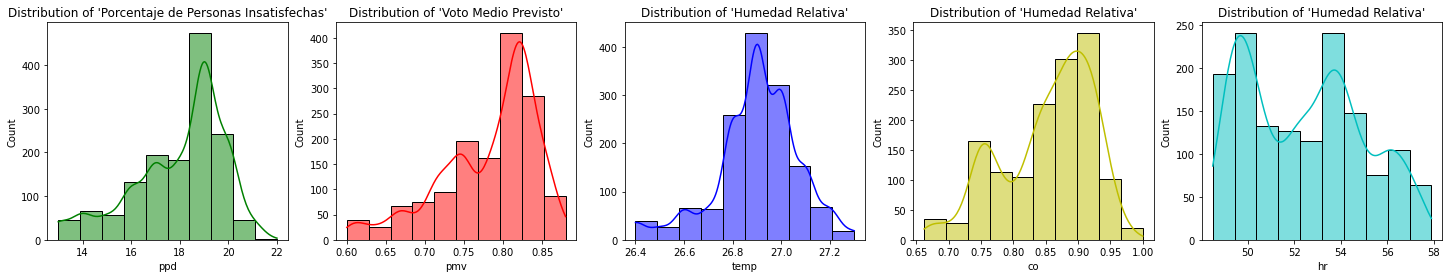

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

sns.histplot(ax = axes[0], x = df["ppd"],
             bins = 10,
             kde = True,
             color = "g").set(title = "Distribution of 'Porcentaje de Personas Insatisfechas'");

sns.histplot(ax = axes[1], x = df["pmv"],
             bins = 10,
             kde = True,
             color = "r").set(title = "Distribution of 'Voto Medio Previsto'");

sns.histplot(ax = axes[2], x = df["temp"],
             bins = 10,
             kde = True,
             color = "b").set(title = "Distribution of 'Humedad Relativa'");

sns.histplot(ax = axes[3], x = df["co"],
             bins = 10,
             kde = True,
             color = "y").set(title = "Distribution of 'Humedad Relativa'");

sns.histplot(ax = axes[4], x = df["hr"],
             bins = 10,
             kde = True,
             color = "c").set(title = "Distribution of 'Humedad Relativa'");

Podemos ver que hay correlación entre algunas variables.

#### Correlación
- La correlación indica la fuerza y la dirección de una relación lineal y proporcionalidad entre dos variables estadísticas.

Utilizaremos la función `sns.heatmap()` para ver de manera sencilla la correlación que existe entre nuestras variables.

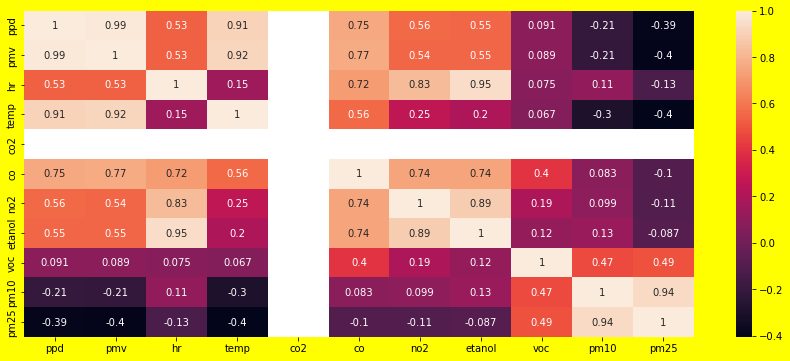

In [12]:
plt.figure(figsize = [15, 6], facecolor = 'yellow')
sns.heatmap(df.corr(), annot=True);

Podemos ver que las variables `pmv` y `co` poseen correlación alta con la variable `ppd`. Con ayuda de la función `regplot()` podemos ver la gráfica que nos muestra la relación lineal entre estas variables.

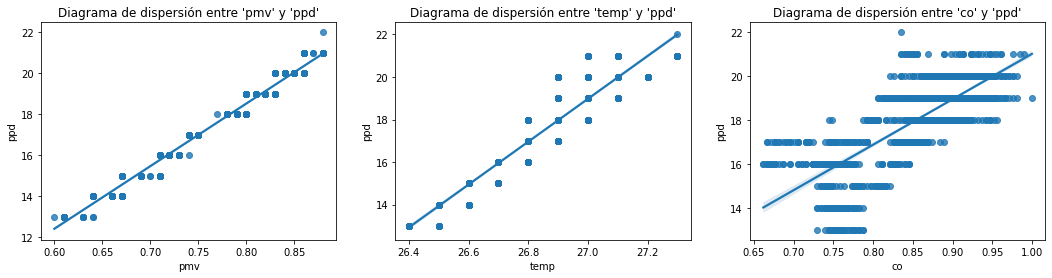

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.regplot(ax = axes[0], x="pmv", y="ppd", data=df);
sns.regplot(ax = axes[1], x="temp", y="ppd", data=df);
sns.regplot(ax = axes[2], x="co", y="ppd", data=df);
axes[0].title.set_text("Diagrama de dispersión entre 'pmv' y 'ppd'")
axes[1].title.set_text("Diagrama de dispersión entre 'temp' y 'ppd'")
axes[2].title.set_text("Diagrama de dispersión entre 'co' y 'ppd'")

#### Valor P
- El valor P es el valor de probabilidad de que la correlación entre dos variables sea estadísticamente significativa.

Entonces a continuación evaluaremos que tan significativa es la relación entre las variables escogidas con ayuda de la función `stats.pearsonr`.

**pmv vs ppd**

In [10]:
from scipy import stats
coeficiente_pearson, valor_p = stats.pearsonr(df['ppd'], df['pmv'])
print("El coeficiente de la Correlación de Pearson es", round(coeficiente_pearson,3), " con un valor de P =", valor_p)

El coeficiente de la Correlación de Pearson es 0.988  con un valor de P = 0.0


Dado que el valor P es $<$ 0.001, la correlación entre el `Voto Medio Previsto (pmv)` y el `Porcentaje de Personas Insatisfechas (ppd)` es estadísticamente significativa.

**temp vs ppd**

In [11]:
from scipy import stats
coeficiente_pearson, valor_p = stats.pearsonr(df['ppd'], df['temp'])
print("El coeficiente de la Correlación de Pearson es", round(coeficiente_pearson,3), " con un valor de P =", valor_p)

El coeficiente de la Correlación de Pearson es 0.908  con un valor de P = 0.0


Dado que el valor P es $<$ 0.001, la correlación entre la `Temperatura (temp)` y el `Porcentaje de Personas Insatisfechas (ppd)` es estadísticamente significativa.

**co vs ppd**

In [12]:
from scipy import stats
coeficiente_pearson, valor_p = stats.pearsonr(df['ppd'], df['co'])
print("El coeficiente de la Correlación de Pearson es", round(coeficiente_pearson,3), " con un valor de P =", valor_p)

El coeficiente de la Correlación de Pearson es 0.754  con un valor de P = 1.1717160227211844e-264


Dado que el valor P es $<$ 0.001, la correlación entre el `Monoxido de Carbono (co)` y el `Porcentaje de Personas Insatisfechas (ppd)` es estadísticamente significativa.

### Variables importantes
En este punto tenemos una mejor idea de cómo se ven los datos y qué variables debemos tener en cuenta al intentar predecir el Porcentaje de Personas Insatisfechas (ppd).

Variables numéricas continuas:
- pmv (Voto Medio Previsto)
- temp (Temperatura)
- co (Monoxido de Carbono)

### Crear los conjuntos de datos de prueba y entrenamiento

Necesitamos dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de pruebas. De esta forma procedemos a entrenar un modelo con el conjunto de entrenamiento y probar la predicción de este modelo con el conjunto de prueba.
Esto nos proporcionará una evaluación más precisa porque el conjunto de datos de prueba no es parte del conjunto de datos que se utilizó para entrenar los datos. Es más realista para los problemas del mundo real.


Así se procederá a dividir el conjunto de datos en conjuntos de entrenamiento y prueba, el 80% del total de los datos para entrenamiento y el 20% para pruebas. Se creará una máscara para seleccionar filas aleatorias usando la función **train_test_split**:

In [34]:
#X4 = df[['pmv','temp', 'co']]
#y4 = df['ppd']
X4 = df.loc[:,['pmv','temp', 'co']].values
y4 = df.loc[:,'ppd'].values

X4_entrena, X4_prueba, y4_entrena, y4_prueba = train_test_split(X4, y4, test_size=0.2, random_state=4)
print ('Conjunto de Entrenamiento set:', X4_entrena.shape,  y4_entrena.shape)
print ('Conjunto de Prueba:', X4_prueba.shape,  y4_prueba.shape)

Conjunto de Entrenamiento set: (1152, 3) (1152,)
Conjunto de Prueba: (288, 3) (288,)


In [30]:
y4

array([21., 22., 21., ..., 18., 20., 19.])

Otra alternativa es utilizar la función **np.random.rand()**:

In [1]:
#np.random.seed(3)
#mascara = np.random.rand(len(df)) < 0.8
#entrena = df[mascara]
#prueba = df[~mascara]

data_dmatrix = xgb.DMatrix(X,label=y)## Modelo XGBoost
- Este tipo de 

Como tenemos 3 variables.

Entonces desarrollamos un modelo usando estas variables como variables predictoras.

In [42]:
data_dmatrix = xgb.DMatrix(X4,label=y4)
data_dmatrix

Entrenamiento del modelo

In [43]:
#Configurar los parametros del modelo
reg_mod = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.08,
    subsample=0.75,
    colsample_bytree=1, 
    max_depth=7,
    gamma=0,
)

reg_mod.fit(X4_entrena, y4_entrena)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [48]:
scores = cross_val_score(reg_mod, X4_entrena, y4_entrena,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.98


In [53]:
reg_mod.fit(X4_entrena,y4_entrena)

predicciones = reg_mod.predict(X4_prueba)

In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(y4_prueba, predicciones))
r2 = np.sqrt(r2_score(y4_prueba, predicciones))
print("RMSE: %f" % (rmse))
print("R_Squared Score : %f" % (r2))


RMSE: 0.259794
R_Squared Score : 0.990722


As you can see, the these statistical metrics have reinstated our confidence about this model. RMSE ~ 4.95 R-Squared Score ~ 98.8% Now, let's visualize the original data set using the seaborn library.

<AxesSubplot:xlabel='pmv', ylabel='ppd'>

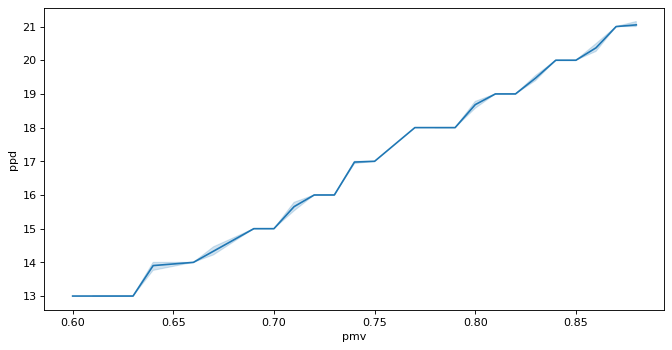

In [61]:
plt.figure(figsize=(10, 5), dpi=80)
sns.lineplot(x='pmv', y='ppd', data=df)

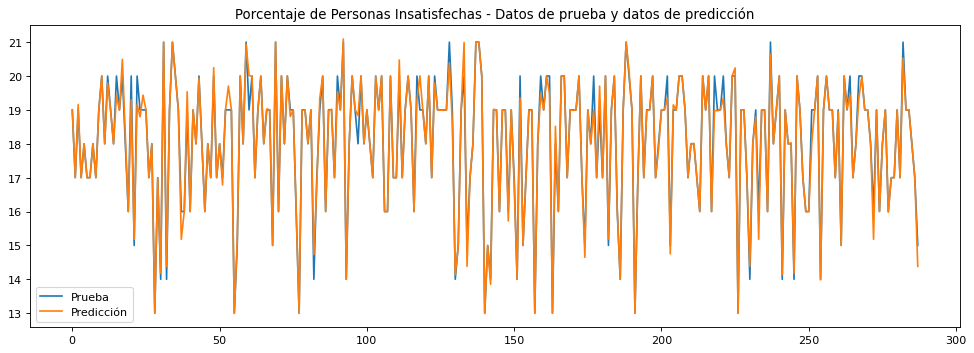

In [65]:
plt.figure(figsize=(15, 5), dpi=80)
x_ax = range(len(y4_prueba))
plt.plot(x_ax, y4_prueba, label="Prueba")
plt.plot(x_ax, predicciones, label="Predicción")
plt.title("Porcentaje de Personas Insatisfechas - Datos de prueba y datos de predicción")
plt.legend()
plt.show()

#### Gráfico de resultados
Cuando se trata de regresión lineal simple, una excelente manera de visualizar el ajuste de nuestro modelo es mediante un gráfico de regresión o uno de residuos.

Este gráfico mostrará una combinación de puntos de datos dispersos, así como la línea de regresión lineal ajustada que pasa por los datos.

Text(0, 0.5, 'Porcentaje de Personas Insatisfechas')

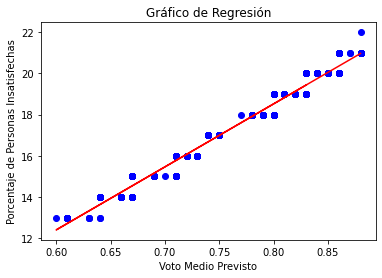

In [16]:
entrena_Y_hat_RLS = regresion_lineal.predict(X)

plt.scatter(entrena.pmv, entrena.ppd,  color='blue')
plt.plot(entrena['pmv'], entrena_Y_hat_RLS, '-r')
plt.title("Gráfico de Regresión")
plt.xlabel("Voto Medio Previsto")
plt.ylabel("Porcentaje de Personas Insatisfechas")

De este gráfico se puede observar que el valor de pmv está positivamente correlacionado con el de ppd, ya que la pendiente de la regresión es positiva. Además podemos ver que los puntos de datos alrededor de la línea de regresión no se encuentran muy dispersos, esto nos da una buena indicación de la variación de los datos.

#### Evaluación
Finalmente comparamos los valores reales y los valores pronosticados para calcular la precisión del modelo de regresión.

Se utilizan las siguientes 3 metricas para brindar información sobre las áreas que requieren mejoras:
* **Error absoluto medio**: Es la media del valor absoluto de los errores. Esta es la métrica más fácil de entender, ya que es solo un error promedio.
* **Error cuadrático medio (MSE)**: el error cuadrático medio (MSE) es la media del error cuadrático. Es más popular que el error absoluto medio porque se centra más en los errores grandes. Esto se debe a que el término al cuadrado aumenta exponencialmente los errores más grandes en comparación con los más pequeños.
* **R-cuadrado** es la métrica más popular para calcular la precisión de un modelo. Representa qué tan cerca están los datos de la línea de regresión ajustada. Cuanto mayor sea el R-cuadrado, mejor se ajustará el modelo a los datos. La mejor puntuación posible es 1,0 y puede ser negativa (porque el modelo puede ser arbitrariamente peor).


In [17]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

prueba_X_RLS = prueba[['pmv']]
prueba_Y_RLS = prueba['ppd']
prueba_Y_hat_RLS = regresion_lineal.predict(prueba_X_RLS)

abs_RLS = mean_absolute_error(prueba_Y_RLS, prueba_Y_hat_RLS)
mse_RLS = mean_squared_error(prueba_Y_RLS, prueba_Y_hat_RLS)
r2_RLS = r2_score(prueba_Y_RLS, prueba_Y_hat_RLS)

print("Error absoluto medio: %.2f" % abs_RLS)
print("Error cuadrático medio (MSE): %.2f" % mse_RLS)
print("Calificación R²: %.3f" % r2_RLS)

Error absoluto medio: 0.25
Error cuadrático medio (MSE): 0.09
Calificación R²: 0.975


El valor entregado de $R^2$ nos indica que el ~97,5% de la variación del precio se explica por el modelo lineal simple basado en `pmv`.

## Regresión Lineal Múltiple
- Este tipo de Regresión se utiliza para explicar la relación entre una variable de respuesta continua (dependiente) y dos o más variables predictoras (independientes)

Como tenemos 3 variables que podemos utilizar para predecir el valor de ppd, se puede usar una Regresión Lineal Múltiple.

Entonces desarrollamos un modelo usando estas variables como variables predictoras.

In [18]:
#Cargamos el modulo y creamos un objeto del tipo regresión lineal  LinearRegression()
regresion_lineal_m = LinearRegression()

#Entrenar/Ajustar el modelo lineal multiple utilizando las 3 variables mencionadas anteriormente.
Z = entrena[['pmv','temp', 'co']]
Y = entrena['ppd']
regresion_lineal_m.fit(Z, Y)


# Los coeficientes obtenidos
print ('Coeficientes: ', regresion_lineal_m.coef_)
print ('Intersección: ',regresion_lineal_m.intercept_)

Coeficientes:  [30.84536997 -0.06101231 -0.10823036]
Intersección:  -4.417339895605984


#### Gráfico de resultados
En este caso no podemos visualizar el comportamiento del modelo con un gráfico de regresión o de residuos. Una alternativa es ver el ajuste del modelo con un gráfico de distribución utilizando el método `.kdeplot()`, de esta forma podemos observar la distribución de los valores ajustados que resultan del modelo y compararla con la distribución de los valores reales.

In [19]:
Y_hat = regresion_lineal_m.predict(Z)

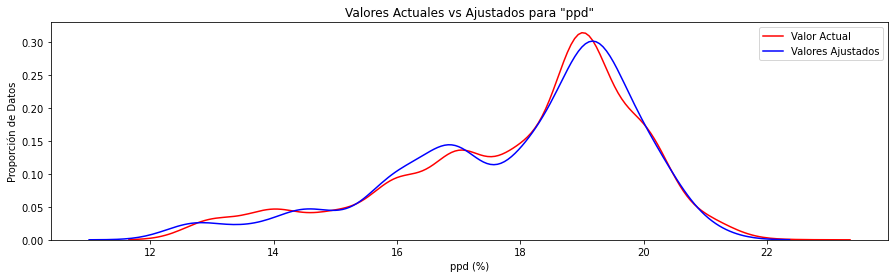

In [20]:
plt.figure(figsize=(15, 4))

ax1 = sns.kdeplot(df['ppd'], color="r", label="Valor Actual")
sns.kdeplot(Y_hat, color="b", label="Valores Ajustados" , ax=ax1)

plt.title('Valores Actuales vs Ajustados para "ppd"')
plt.xlabel('ppd (%)')
plt.ylabel('Proporción de Datos')

plt.legend(loc='upper right')

plt.show()
plt.close()

Del gráfico se puede observar que los valores ajustados para estas 3 variables están razonablemente cerca de los valores reales, ya que las dos distribuciones se superponen un poco. Sin embargo, definitivamente hay algo de espacio para mejorar.

#### Evaluación
Finalmente comparamos los valores reales y los valores pronosticados para calcular la precisión del modelo de regresión.

Se utilizaran las 3 metricas señaladas anteriormente para brindar información sobre las áreas que requieren mejoras.

In [21]:
prueba_Z_RLM = prueba[['pmv','temp', 'co']]
prueba_Y_RLM = prueba['ppd']
prueba_Y_hat_RLM = regresion_lineal_m.predict(prueba_Z_RLM)

abs_RLM = mean_absolute_error(prueba_Y_RLM, prueba_Y_hat_RLM)
mse_RLM = mean_squared_error(prueba_Y_RLM, prueba_Y_hat_RLM)
r2_RLM = r2_score(prueba_Y_RLM, prueba_Y_hat_RLM)

print("Error absoluto medio: %.2f" % abs_RLM)
print("Error cuadrático medio (MSE): %.2f" % mse_RLM)
print("Calificación R²: %.3f" % r2_RLM)

Error absoluto medio: 0.24
Error cuadrático medio (MSE): 0.09
Calificación R²: 0.975


El valor entregado de $R^2$ nos indica que el ~97,5% de la variación del `Porcentaje de Personas Insatisfechas(ppd)` se explica por el modelo lineal multiple basado en las variables `pmv (Voto Medio Previsto)`, `temp (Temperatura)` y `co (Monoxido de Carbono)`.

## Regresión Polinomial
- Este tipo de Regresión obtiene relaciones no lineales elevando al cuadrado o estableciendo términos de orden superior de las variables predictoras.

Como tenemos 3 variables que podemos utilizar para predecir el valor de ppd, se puede usar una Regresión Polinomial.

Entonces desarrollamos un modelo usando estas variables como variables predictoras.

In [22]:
from sklearn.preprocessing import PolynomialFeatures

#
X_RP = entrena[['pmv','temp', 'co']]

#Definir grado del polinomio
regresion_poly = PolynomialFeatures(degree = 5)
#Transformamos a caracteristicas de mayor grado
X_RP_train = regresion_poly.fit_transform(X_RP)
X_RP_test = regresion_poly.fit_transform(prueba[['pmv','temp', 'co']])

#Defimos el algoritmo a utilizar
RP = LinearRegression()
#Entreno del modelo
RP.fit(X_RP_train, entrena['ppd'])

#print ('Coeficientes: ', RP.coef_)
print ('Intersección: ', RP.intercept_)
print('Precisión del modelo: %.5f' % RP.score(X_RP_test, prueba[['ppd']]))

Intersección:  196530649.33458132
Precisión del modelo: 0.98064


Es importante considerar el grado del polinomio que vamos a utilizar para entrenar nuestro modelo, en este caso `degree = 5`. Se debe partir probando con un grado 2 e ir subiendo poco a poco para ver si mejora el resultado de la predicción.
En el caso de no tener cuidado con el grado puesto podemos ajustar de más el modelo probocando un sobreajuste u overfitting que empeorará los resultados de la predicción.

#### Gráfico de resultados
En este caso como utilizamos más de una variable tampoco podemos visualizar el comportamiento del modelo con un gráfico de regresión.

Primero debemos realizar una predicción usando el método `predict()` con los datos de prueba para ver un resultado del modelo y así poder graficar. Para ello, se va a asignar los valores del resultado a la variable `Y_hat_RP`.

In [23]:
Y_hat_RP = RP.predict(X_RP_test)

Entonces podemos ver el ajuste del modelo con un gráfico de distribución utilizando el método `.kdeplot()`, de esta forma podemos observar la distribución de los valores ajustados que resultan del modelo y compararla con la distribución de los valores reales.

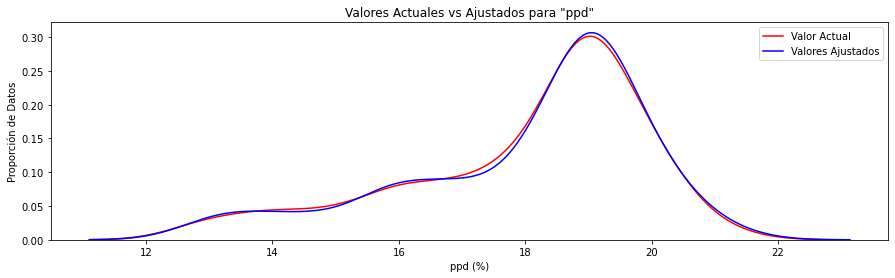

In [24]:
plt.figure(figsize=(15, 4))

ax1 = sns.kdeplot(prueba['ppd'], color="r", label="Valor Actual")
sns.kdeplot(Y_hat_RP, color="b", label="Valores Ajustados" , ax=ax1)

plt.title('Valores Actuales vs Ajustados para "ppd"')
plt.xlabel('ppd (%)')
plt.ylabel('Proporción de Datos')

plt.legend(loc='upper right')

plt.show()
plt.close()

#### Evaluación
Finalmente comparamos los valores reales y los valores pronosticados para calcular la precisión del modelo de regresión.

Se utilizaran las 3 metricas señaladas anteriormente para brindar información sobre las áreas que requieren mejoras.

In [25]:
abs_RP = mean_absolute_error(prueba['ppd'], Y_hat_RP)
mse_RP = mean_squared_error(prueba['ppd'], Y_hat_RP)
r2_RP = r2_score(prueba['ppd'], Y_hat_RP)

print("Error absoluto medio: %.2f" % abs_RP)
print("Error cuadrático medio (MSE): %.2f" % mse_RP)
print("Calificación R²: %.3f" % r2_RP)

Error absoluto medio: 0.18
Error cuadrático medio (MSE): 0.07
Calificación R²: 0.981


El valor entregado de $R^2$ nos indica que el ~98,1% de la variación del `Porcentaje de Personas Insatisfechas(ppd)` se explica por el modelo lineal multiple basado en las variables `pmv (Voto Medio Previsto)`, `temp (Temperatura)` y `co (Monoxido de Carbono)`.

## Cuál es el mejor modelo?
Ordenamos los valores de $R^2$ calculados para cada modelo utilizando los datos de prueba y ver de manera sencilla qué modelo arrojó mejores resultados.

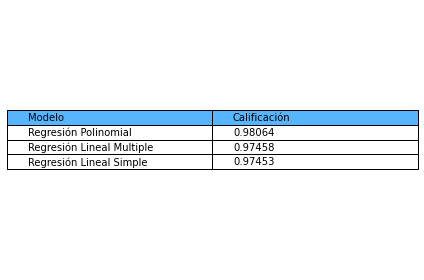

In [26]:
best_model = pd.DataFrame({
    'Modelo': ['Regresión Lineal Simple','Regresión Lineal Multiple','Regresión Polinomial'], 
    'Calificación': [round(r2_RLS,5),round(r2_RLM,5),round(r2_RP,5)]})
best_model.sort_values(by=['Calificación'], ascending=False, inplace=True)
best_model.reset_index(inplace=True, drop=True)

#define figure and axes
fig, ax = plt.subplots()
#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

#create table
tableR = ax.table(cellText=best_model.values, colLabels=best_model.columns, cellLoc='left',colLoc='left', loc='center', colColours=["#56b5fd","#56b5fd"])

#display table
fig.tight_layout()
plt.show()

## $\therefore$ Conclusión

Comparando estos tres modelos, se concluye que la **Regresión Polinomial (grado 5)** es el mejor modelo para poder predecir los valores de `ppd` a partir de nuestro conjunto de datos. Este resultado tiene sentido, ya que tenemos 14 variables en total y sabemos que más de una de esas variables son predictores potenciales del Porcentaje de Personas Insatisfechas en la zona del Hospital evaluada.